In [2]:
# Bike Sharing Demand Prediction

# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# 2. Load Dataset
df = pd.read_excel("day.xlsx")
print("Shape:", df.shape)
df.head()

Shape: (731, 16)


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [3]:
# Check for missing values
print(df.isnull().sum())

# Convert date column to datetime
df['dteday'] = pd.to_datetime(df['dteday'])

# Drop 'instant' if present (it's just a row index)
if 'instant' in df.columns:
    df.drop(columns=['instant'], inplace=True)

# Separate features & target
target = 'cnt'
X = df.drop(columns=[target, 'casual', 'registered'])  # We'll predict cnt directly first
y = df[target]

# Categorical and numerical columns
categorical_cols = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
numeric_cols = [col for col in X.columns if col not in categorical_cols and col != 'dteday']

# OneHotEncoding for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_cols),
        ('num', 'passthrough', numeric_cols)
    ]
)

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64


In [4]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, random_state=42)
}

results = {}

for name, model in models.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}

# Convert to DataFrame
results_df = pd.DataFrame(results).T
print(results_df)

                          MAE        RMSE        R2
Linear Regression  583.019829  796.461841  0.841803
Random Forest      470.370612  714.907003  0.872542
Gradient Boosting  476.950691  683.574757  0.883469


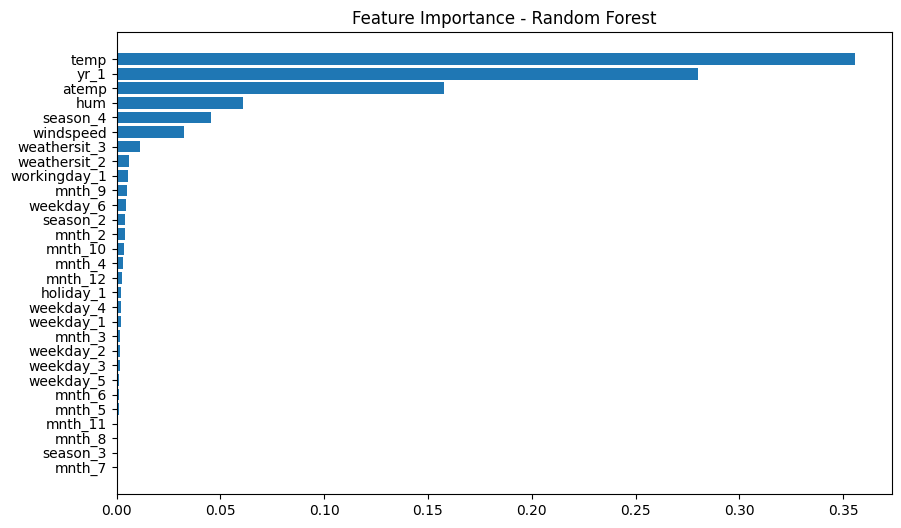

In [5]:
# Example: Feature importance for Random Forest
rf_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', RandomForestRegressor(n_estimators=200, random_state=42))])
rf_pipe.fit(X_train, y_train)

# Extract feature names
cat_features = rf_pipe.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_cols)
num_features = numeric_cols
all_features = np.concatenate([cat_features, num_features])

importances = rf_pipe.named_steps['model'].feature_importances_

feat_imp = pd.DataFrame({"Feature": all_features, "Importance": importances})
feat_imp = feat_imp.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feat_imp["Feature"], feat_imp["Importance"])
plt.gca().invert_yaxis()
plt.title("Feature Importance - Random Forest")
plt.show()

In [6]:
# Predict casual
y_casual = df['casual']
y_registered = df['registered']

def train_and_evaluate(target):
    X_temp = df.drop(columns=[target, 'cnt', 'casual', 'registered'])
    y_temp = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)
    
    model = RandomForestRegressor(n_estimators=200, random_state=42)
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    
    return preds, y_test

casual_preds, casual_y_test = train_and_evaluate('casual')
registered_preds, registered_y_test = train_and_evaluate('registered')

# Sum predictions for cnt
cnt_preds = casual_preds + registered_preds
cnt_actual = casual_y_test.values + registered_y_test.values

print("Brownie Point Model Metrics:")
print("MAE:", mean_absolute_error(cnt_actual, cnt_preds))
print("RMSE:", np.sqrt(mean_squared_error(cnt_actual, cnt_preds)))
print("R2:", r2_score(cnt_actual, cnt_preds))

Brownie Point Model Metrics:
MAE: 471.316768707483
RMSE: 739.0389618383703
R2: 0.863791865244982
